## Plotting composites ##

Plotting composites for two types of very bad winter days across three datasets: ERA5, DePreSys (10 members, Nov. init, first DJF), and CANARI (40 members, DJF).

1. Worst wind cold temp events - for each winter, this is where I've selected the day with the lowest wind speed and taken the corresponding temperature on that 'worst wind' day. I have then plotted these as a scatter and identified the very bad days, which are in both the 0th-50th percentile of the wind speeds for worst wind days and 0th-50th percentile of temperature for the worst temp days. These very bad days are what I am plotting as composites here.

2. Worst temp low wind events, same as above, but for the lowest temperature and then taking the corresponding wind speed.

In [1]:
import os
import sys
import glob

import iris
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Set up the file to the
worst_temp_path = (
    "/home/users/benhutch/unseen_multi_year/dfs/obs_worst_temp_low_wind_djf.csv"
)
worst_wind_path = (
    "/home/users/benhutch/unseen_multi_year/dfs/obs_worst_wind_cold_temp_djf.csv"
)

# load these datarames
worst_temp = pd.read_csv(worst_temp_path)
worst_wind = pd.read_csv(worst_wind_path)

In [3]:
# extract the worst temp dates
worst_temp_dates = worst_temp["time_worst_tas_date"].values
worst_temp_dates = pd.to_datetime(worst_temp_dates)

# extract the worst wind dates
worst_wind_dates = worst_wind["time_worst_wind_date"].values
worst_wind_dates = pd.to_datetime(worst_wind_dates)

# print these
print(worst_temp_dates)
print(worst_wind_dates)

DatetimeIndex(['1977-01-12', '2008-12-31'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1977-01-12', '1981-12-10'], dtype='datetime64[ns]', freq=None)


In [4]:
# Set up the path to the data
data_path = (
    "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_msl_daily_1960_2020_daymean.nc"
)

# Load the data
psl_cube = iris.load_cube(data_path, "msl")

In [79]:
# define a function to plot the daily anoms or composites for a list of dates
# given the cube and the dates
def plot_daily_field(
    cube: iris.cube.Cube,
    dates: list,
    title: str,
    anoms: bool = False,  # By default, plot the absolute field
    composite: bool = False,  # By default, plot all of the dates as subplots
    months: list = [12, 1, 2],
    climatology_years: list = [1990, 2020],
) -> None:
    """
    Plots the daily field for a list of dates

    Args:
    ----

        cube: iris.cube.Cube
            The cube of the field
        dates: list
            A list of dates to plot
        title: str
            The title of the plot
        anoms: bool
            Whether to plot the anomalies or the absolute field
        composite: bool
            Whether to plot all of the dates as subplots
        months: list
            The months to extract
        climatology_years: list
            The years to use for the climatology

    Returns:
    -------

        None

    """

    # Convert the dates to cf time.datetime objects
    dates_this = [cftime.datetime(d.year, d.month, d.day) for d in dates]

    # Extract the dates from the cube
    cube_dates = cube.coord("time").points

    # Extract the time units and calendar from the time coordinate
    cube_time_units = cube.coord("time").units
    cube_calendar = cube.coord("time").units.calendar

    # Extract the date values from theb cube
    cube_datetime_values = cftime.num2date(
        cube_dates, units=cube_time_units.origin, calendar=cube_calendar
    )

    # Convert to cf time.datetime objects
    cube_datetime_values = [
        cftime.datetime(d.year, d.month, d.day) for d in cube_datetime_values
    ]

    # Print the dates this
    print(f"Dates to extract: {dates_this}")
    print(f"type of dates: {type(dates_this[0])}")

    # Print the cube dates
    print(f"Cube dates: {cube_datetime_values}")
    print(f"type of cube dates: {type(cube_datetime_values[0])}")

    # Set up an empty cube list
    cube_list = iris.cube.CubeList([])

    # Loop through the dates
    for date in dates_this:
        # Find the index of the date in the datetime values
        index = np.where(np.array(cube_datetime_values) == date)[0][0]

        # Extract the cube at the index
        cube_this = cube[index]

        # Append this cube to the list
        cube_list.append(cube_this)

    # Merge the cubes
    cube_merged = cube_list.merge_cube()

    # if anoms is true, calculate the climatology
    if anoms:
        # Extract the DJF data
        cube_djf = cube.extract(
            iris.Constraint(time=lambda cell: cell.point.month in months)
        )

        # Extract the 1990-2020 data
        cube_djf_1990_2020 = cube_djf.extract(
            iris.Constraint(
                time=lambda cell: climatology_years[0]
                <= cell.point.year
                <= climatology_years[1]
            )
        )

        # Take the mean over the time dimension
        cube_djf_1990_2020_mean = cube_djf_1990_2020.collapsed(
            "time", iris.analysis.MEAN
        )

        # Calculate the anomalies
        cube_anoms = cube_merged - cube_djf_1990_2020_mean

        # Set the cube merged to the cube anoms
        cube_merged = cube_anoms

        # Set up the clevs
        clevs = np.array(np.arange(-41, 41 + 1, 2))

        # remove the zero
        if 0 in clevs:
            clevs = np.delete(clevs, np.where(clevs == 0))

        ticks = clevs

        # ensure that these are floats
        clevs = clevs.astype(float)
        ticks = ticks.astype(float)

    else:
        # Set the cube merged to the cube
        cube_merged = cube_merged

        # Set up the clevs and ticks for absolution values
        clevs = np.array(np.arange(988, 1032 + 1, 4))
        ticks = clevs

        # ensure that these are floats
        clevs = clevs.astype(float)
        ticks = ticks.astype(float)

    # Set up the custom colormap
    # custom colormap
    cs = [
        "#4D65AD",
        "#3E97B7",
        "#6BC4A6",
        "#A4DBA4",
        "#D8F09C",
        "#FFFEBE",
        "#FFD27F",
        "#FCA85F",
        "#F57244",
        "#DD484C",
        "#B51948",
    ]
    cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

    # Set up the lons and lats
    lons = cube.coord("longitude").points
    lats = cube.coord("latitude").points

    # extract the field
    field_3d = cube_merged.data

    # if composite is true, plot a single plot
    if composite:
        print(f"Average over {len(dates_this)} dates")

        # Set up the figure
        fig, ax = plt.subplots(
            figsize=(12, 5), subplot_kw={"projection": ccrs.PlateCarree()}
        )

        # Set up the str for the date
        # remove the HH:MM:SS
        date_this_str = dates_this[0].strftime("%Y-%m-%d")

        # Set up the title
        # ax.set_title(f"{date_this_str}", fontsize=10, fontweight="bold")

        # Set up the field this
        field_this = np.mean(field_3d, axis=0)

        # Plot the data
        mymap = ax.contourf(
            lons,
            lats,
            field_this / 100,
            clevs,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            extend="both",
        )

        contours = ax.contour(
            lons,
            lats,
            field_this / 100,
            clevs,
            colors="black",
            transform=ccrs.PlateCarree(),
            linewidth=0.2,
            alpha=0.5,
        )

        ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)

        ax.coastlines()

        # restrict the region to include all lons, but only lats between 30 and 80
        ax.set_extent([lons.min(), lons.max(), 30, 80])

        # format the gridlines and labels
        # format the gridlines and labels
        gl = ax.gridlines(
            draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
        )
        gl.xlabels_top = False
        gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {"size": 7, "color": "black"}
        gl.ylabels_right = False
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {"size": 7, "color": "black"}
        gl.ylabels_left = False
        gl.ylabels_right = False

        # turn off the top labels
        gl.top_labels = False
        gl.bottom_labels = False

        # Set a textbox in the top left with the date
        # set up the colorbar
        cbar = plt.colorbar(
            mymap,
            ax=ax,
            orientation="horizontal",
            shrink=0.8,
            pad=0.1,
            format=FuncFormatter(format_func_one_decimal),
        )

        if anoms:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure 1990-2020 DJF anomaly (hPa)",
                rotation=0,
                fontsize=10,
            )
        else:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure (hPa)",
                rotation=0,
                fontsize=10,
            )

        # Add contour lines to the colorbar
        cbar.add_lines(contours)

        # Set up the super title
        plt.suptitle(title, fontsize=12, fontweight="bold")
    else:
        print(f"Plotting {len(dates_this)} dates")

        # Set up the nrows, assuming ncols is 2
        nrows = int(np.ceil(len(dates_this) / 2))

        # Set up the figure
        fig, axs = plt.subplots(
            nrows=nrows,
            ncols=2,
            figsize=(12, 5 * nrows),
            subplot_kw={"projection": ccrs.PlateCarree()},
        )

        # Flatten the axs
        axs = axs.flatten()

        # loop over the zipped axs and dates
        for i, (ax, date) in enumerate(zip(axs, dates_this)):
            # # Set up the projection
            # ax = plt.subplot(1, 2, i + 1, projection=ccrs.PlateCarree())

            # set up the str for the date
            # remove the HH:MM:SS
            date_this_str = date.strftime("%Y-%m-%d")

            # # Set up the title
            # ax.set_title(f"{date}", fontsize=10, fontweight="bold") 

            # set up the field this
            field_this = field_3d[i]

            # Plot the data
            mymap = ax.contourf(
                lons,
                lats,
                field_this / 100,
                clevs,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                extend="both",
            )

            contours = ax.contour(
                lons,
                lats,
                field_this / 100,
                clevs,
                colors="black",
                transform=ccrs.PlateCarree(),
                linewidth=0.2,
                alpha=0.5,
            )

            ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)

            ax.coastlines()

            # restrict the region to include all lons, but only lats between 30 and 80
            ax.set_extent([lons.min(), lons.max(), 30, 80])

            # format the gridlines and labels
            gl = ax.gridlines(
                draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
            )
            gl.xlabels_top = False
            gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
            gl.xformatter = LONGITUDE_FORMATTER
            gl.xlabel_style = {"size": 7, "color": "black"}
            gl.ylabels_right = False
            gl.yformatter = LATITUDE_FORMATTER
            gl.ylabel_style = {"size": 7, "color": "black"}
            gl.ylabels_left = False
            gl.ylabels_right = False

            # turn off the top labels
            gl.top_labels = False
            gl.bottom_labels = False

            # Properly turn off the labels
            # if i is 0
            if i == 0:
                gl.right_labels = False
            elif i == len(dates_this) - 1:
                gl.left_labels = False

            # Set a textbox in the top left with the date
            ax.text(
                0.02,
                0.95,
                f"{date_this_str}",
                verticalalignment="top",
                horizontalalignment="left",
                transform=ax.transAxes,
                color="black",
                fontsize=10,
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
            )

        # Set a tight layout
        plt.tight_layout()

        # Set up the colorbar
        cbar = plt.colorbar(
            mymap,
            ax=axs,
            orientation="horizontal",
            shrink=0.8,
            pad=0.1,
            format=FuncFormatter(format_func_one_decimal),
        )
        
        if anoms:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure 1990-2020 DJF anomaly (hPa)",
                rotation=0,
                fontsize=10,
            )
        else:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure (hPa)",
                rotation=0,
                fontsize=10,
            )

        # Add contour lines to the colorbar
        cbar.add_lines(contours)

        # Set up the super title
        plt.suptitle(title, fontsize=12, fontweight="bold")

    return None

Dates to extract: [cftime.datetime(1977, 1, 12, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1981, 12, 10, 0, 0, 0, 0, calendar='standard', has_year_zero=False)]
type of dates: <class 'cftime._cftime.datetime'>
Cube dates: [cftime.datetime(1960, 1, 1, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1960, 1, 2, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1960, 1, 3, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1960, 1, 4, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1960, 1, 5, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1960, 1, 6, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1960, 1, 7, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1960, 1, 8, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1960, 1, 9, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cft

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


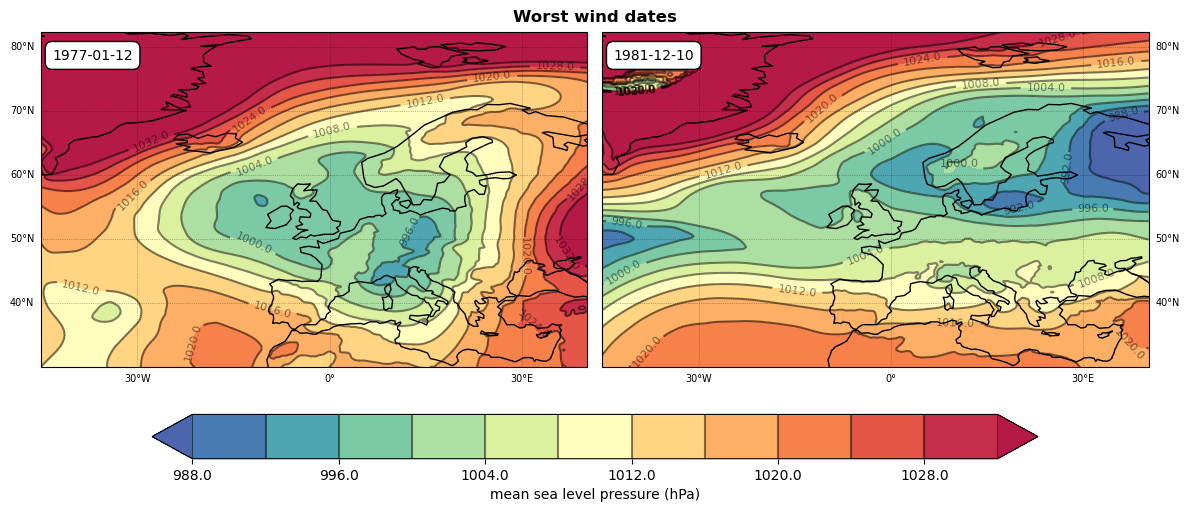

In [68]:
# # test the function
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_wind_dates,
#     title="Worst wind dates",
#     anoms=False,
#     composite=False,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [69]:
# # Extract the new df
# path = "/home/users/benhutch/unseen_multi_year/dfs/ERA5_worst_djf_wind_temp_days_DJF_1960-2013.csv"

# full_obs_df = pd.read_csv(path)

In [71]:
# # Subset to the lowest 20th percentile of wind ("data_wind")
# data_wind_20th = full_obs_df["data_wind"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_wind = full_obs_df[full_obs_df["data_wind"] <= data_wind_20th]


In [75]:
# # extract the dates from this
# worst_wind_20th_dates = full_obs_df_subset_20th_wind["time_worst_wind_date"].values

In [77]:
# # convert these to datetime objects
# worst_wind_20th_dates = pd.to_datetime(worst_wind_20th_dates)

Dates to extract: [cftime.datetime(1963, 2, 22, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1968, 1, 22, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1971, 2, 25, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1973, 2, 26, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1977, 1, 12, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1980, 2, 26, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(2000, 1, 25, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(2002, 12, 20, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(2003, 12, 30, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(2006, 2, 1, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(2012, 2, 6, 0, 0, 0, 0, calendar='standard', has_year_zero=False)]
type of dates: <class 'cftime._cftime.datetime'>
Cube dat

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


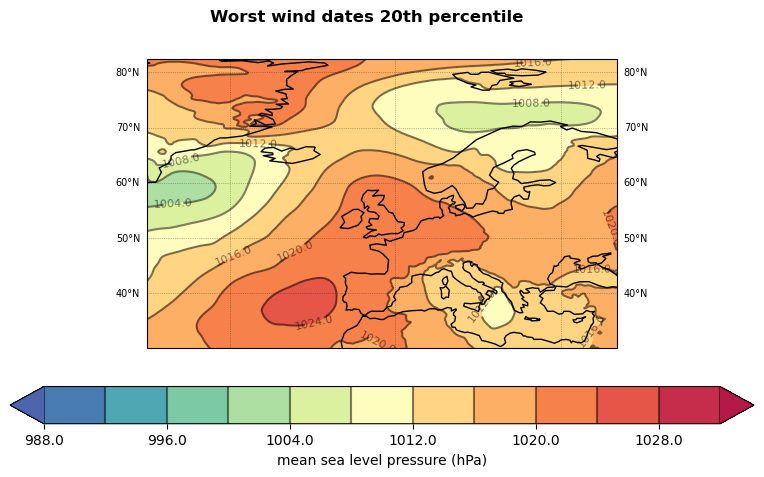

In [80]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_wind_20th_dates,
#     title="Worst wind dates 20th percentile",
#     anoms=False,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [81]:
# # set up the 20th percentile for temperature
# data_tas_20th = full_obs_df["data_tas"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_temp = full_obs_df[full_obs_df["data_tas"] <= data_tas_20th]

# # extract the dates from this
# worst_temp_20th_dates = full_obs_df_subset_20th_temp["time_worst_tas_date"].values

# # convert these to datetime objects
# worst_temp_20th_dates = pd.to_datetime(worst_temp_20th_dates)

In [86]:
# data_tas_20th_dt = full_obs_df["data_tas_dt"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_temp_dt = full_obs_df[full_obs_df["data_tas_dt"] <= data_tas_20th_dt]

# # extract the dates from this
# worst_temp_20th_dates_dt = full_obs_df_subset_20th_temp_dt["time_worst_tas_date"].values

# # assert that these are the same
# assert np.all(worst_temp_20th_dates == full_obs_df_subset_20th_temp["time_worst_tas_date"].values)

Dates to extract: [cftime.datetime(1963, 1, 12, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1966, 1, 19, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1969, 2, 16, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1972, 1, 31, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1979, 1, 13, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1982, 1, 10, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1985, 12, 29, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1987, 1, 12, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1995, 12, 28, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(2010, 1, 7, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(2010, 12, 20, 0, 0, 0, 0, calendar='standard', has_year_zero=False)]
type of dates: <class 'cftime._cftime.datetime'>
Cube d

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


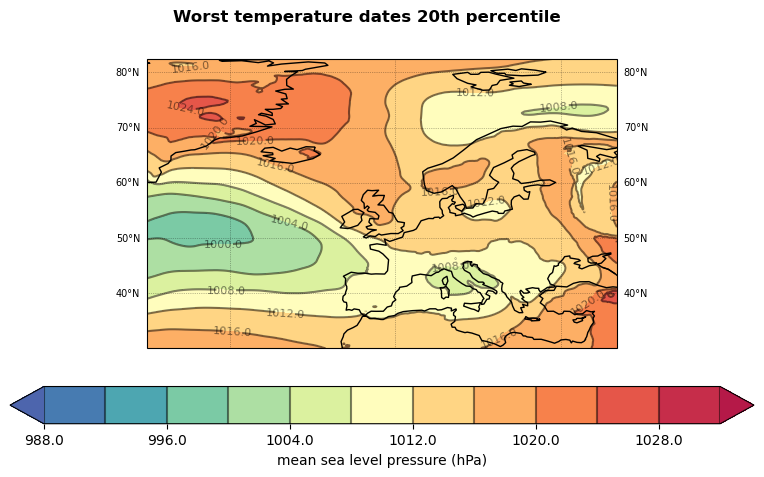

In [83]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_temp_20th_dates,
#     title="Worst temperature dates 20th percentile",
#     anoms=False,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [87]:
# # extract all of the dates for time_worst wind
# worst_wind_dates = full_obs_df["time_worst_wind_date"].values

# # convert these to datetime objects
# worst_wind_dates = pd.to_datetime(worst_wind_dates)

# # extract all of the dates for time_worst tas
# worst_temp_dates = full_obs_df["time_worst_tas_date"].values

# # convert these to datetime objects
# worst_temp_dates = pd.to_datetime(worst_temp_dates)

Dates to extract: [cftime.datetime(1961, 1, 11, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1962, 1, 1, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1963, 1, 12, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1963, 12, 20, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1964, 12, 28, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1966, 1, 19, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1967, 1, 8, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1967, 12, 8, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1969, 2, 16, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1970, 1, 7, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1971, 1, 3, 0, 0, 0, 0, calendar='standard', has_year_zero=False), cftime.datetime(1972, 1, 31, 0, 0, 0, 0, calendar='standard

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(


Average over 54 dates


/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


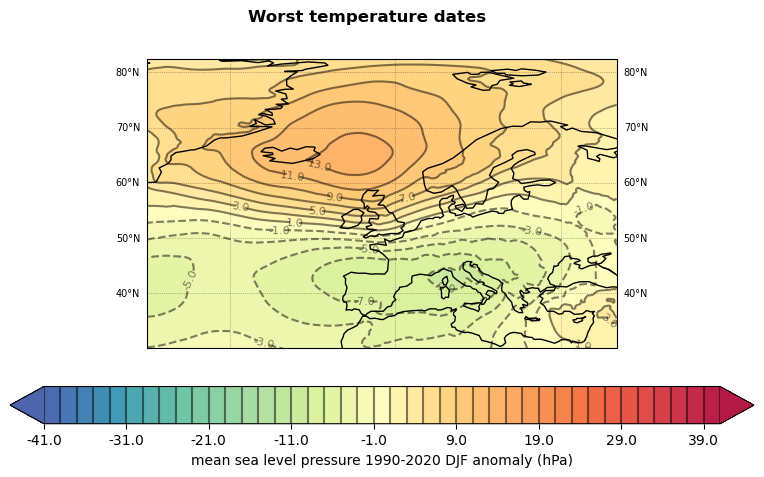

In [90]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_temp_dates,
#     title="Worst temperature dates",
#     anoms=True,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [92]:
# # same buyt for the wind
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_wind_dates,
#     title="Worst wind dates",
#     anoms=True,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )